# SETUP

You will need to upload `gen_data.py` for this to work. You'll also need to set up spark as in the spark notebooks.

In [59]:
# Installing java and downloading spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Summative

This exercise will go through a simulated streaming data workflow, as seen in the streaming data module. But it will be more complex, and closer to what a real world scenario might look like. You will need to 
- Investigate the incoming data
- Create an appropriate database to store the incoming records
- Write code to process records one by one as they arrive, including
 - Printing warnings when any reading goes above a predefined threshold
 - Storing the incoming data in a database
- Write code to analyse the stored data in a scalable manner
- Display relevant information in a dashboard

## Create an appropriate database

Each incoming record will look something like the following: 

{'Device_ID': 9,                  
  'Temp1': 33.01235436945101,  
  'Temp2': 46.313589806396116,  
  'Temp3': 16.506177184725505,  
  'Temp_Ambient': 23.782493817278034}
  
Each device is assigned an integer ID. Every device has multiple sensors, and reports the readings from each sensor as a float. Each call to gen_data.getReading() returns a time (an integer here to make things easier) and a record that follows the same pattern as above.

<b>Create a database to store the incoming data.</b> Include a time field for the time that the data arrives. If you create the database with python, show the code here, otherwise include any bash or sql code you run. You may wish to come back and add additional fields to make later analysis easier.

### ON COLAB: You can just show the appropriate SQL code, and then continue using an alternative (like a dataframe, saved to CSV) for the rest of the assignment.

In [ ]:
CREATE DATABASE TEMPERATURES
CREATE TABLE gen_data(
  Device_ID int(11),
  Temp1 float,
  Temp2 float,
  Temp3 float,
  Temp_Ambient float,
);

## Store and process the incoming data

As each record arrives (i.e. each loop of the for loop), you must
- <b>Store the record in the database you created above
- Use either moving windows or exponential averaging to keep track each sensor value for each device. Print out the values at the end of the loop
- Print a warning if any reported temperature exceeds 100 degrees for the first time for that device</b>

In [33]:
import gen_data 


for i in range(50): #Making this lower for testing purposes
    
    # Simulated data arriving 
    arrival_time, data = gen_data.getReading()
    
    print(data)
    

{'Device_ID': 1, 'Temp1': 75.46353886706822, 'Temp2': 93.00989275377505, 'Temp3': 37.73176943353411, 'Temp_Ambient': 17.340405815062386}
{'Device_ID': 0, 'Temp1': 74.58757353730283, 'Temp2': 92.04633089103312, 'Temp3': 37.293786768651415, 'Temp_Ambient': 16.637352413489108}
{'Device_ID': 6, 'Temp1': 56.321552016201466, 'Temp2': 71.95370721782162, 'Temp3': 28.160776008100733, 'Temp_Ambient': 17.42867353359324}
{'Device_ID': 0, 'Temp1': 74.58676777962442, 'Temp2': 92.04544455758688, 'Temp3': 37.29338388981221, 'Temp_Ambient': 17.10426625118841}
{'Device_ID': 6, 'Temp1': 56.63626305198849, 'Temp2': 72.29988935718734, 'Temp3': 28.318131525994247, 'Temp_Ambient': 16.98083025420404}
{'Device_ID': 2, 'Temp1': 34.98356831053065, 'Temp2': 48.481925141583716, 'Temp3': 17.491784155265325, 'Temp_Ambient': 16.85229294791211}
{'Device_ID': 8, 'Temp1': 32.33253205528522, 'Temp2': 45.56578526081375, 'Temp3': 16.16626602764261, 'Temp_Ambient': 16.98561724741093}
{'Device_ID': 4, 'Temp1': 30.58146387822

## Analyzing the stored data

You now have a nice big database. <b>Load it into spark for analysis.</b>

You are told that during the time the data was being collected, devices 3 and 10 had malfunctioning sensors - their temperature3 readings are all 200+. <b>Verify this.</b> Since the engineers knew about the faulty sensors, no harm has been done, but seeing those false readings in the historical data makes you unhappy. You decide to go the extra mile and replace these readings with slightly more believable (but still false) data, to practise your new machine learning skills.

<b>Using the other devices for training, build a model to predict temperature3 given readings from the other sensors. Use the model to replace the erroneous values with the predicted ones. 
    
Do you think this is a reasonable step to take? Explain.</b> 

In [64]:
import pandas as pd
window = [] # The moving window
ErroLog = []
df = pd.DataFrame(columns=['Time', 'Device_ID', 'Temp1', 'Temp2', 'Temp3','Temp_Ambient'])


for i in range(50): 
    
    # Siimulating data arriving
    arrival_time, data = gen_data.getReading()
    window.append(data) # Add the record to our moving window
    if len(window)>10: # Keep the window size from growing beyond 10:
        del(window[0]) # If the window is >10 items, delete the oldest
   
    # And add the reading and calculated values to a database (or in this case just a pandas DataFrame)
    df = pd.concat([df, pd.DataFrame([{'Time': arrival_time, 'Device_ID': data['Device_ID'],
                                       'Temp1':data['Temp1'], 
                                       'Temp2':data['Temp2'],
                                       'Temp3':data['Temp3'], 
                                       'Temp_Ambient':data['Temp_Ambient']}])], ignore_index=True)
                                       
    if (data['Temp1'] > 200 or data['Temp2'] > 200 or data['Temp3'] > 200 or data['Temp_Ambient'] > 200):
         if data['Device_ID'] not in ErroLog:
            ErroLog.append(data['Device_ID'])
            print("Device %s sensors has a temperature above 200 degrees" %data['Device_ID'])

df.head() # The first few rows

Device 10 sensors has a temperature above 200 degrees
Device 3 sensors has a temperature above 200 degrees


,Time,Device_ID,Temp1,Temp2,Temp3,Temp_Ambient
0,493,6,52.401492,67.641641,26.200746,17.606782
1,506,5,30.223962,43.246358,15.111981,17.122991
2,516,0,70.845767,87.930343,35.422883,17.601719
3,485,7,25.643925,38.208317,12.821962,17.171377
4,516,0,72.400504,89.640555,36.200252,17.315266


In [61]:
# Start up the spark App
import findspark
findspark.init()
from pyspark.sql import SparkSession 
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [65]:
#Creating a spark DataFrame 
df_1 = spark.createDataFrame(df)
df_1.head()

Row(Time=493, Device_ID=6, Temp1=52.401491932424086, Temp2=67.6416411256665, Temp3=26.200745966212043, Temp_Ambient=17.60678194290574)

In [67]:
df_1.dtypes

[('Time', 'bigint'),
 ('Device_ID', 'bigint'),
 ('Temp1', 'double'),
 ('Temp2', 'double'),
 ('Temp3', 'double'),
 ('Temp_Ambient', 'double')]

In [72]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [73]:
# Split the data into training and test sets
(trainingData, testData) = df_1.randomSplit([0.8, 0.2])

#create an assember using readings from other sensors
assembler = VectorAssembler(inputCols = ['Temp1',
                                          'Temp2',
                                          'Temp_Ambient'], 
                            outputCol = "features")

# using k-means since this is an anomaly detection problem
kmeans = KMeans(featuresCol='features', predictionCol='Temp3_Pred',k=4)

#transform data using pipeline
pipeline = Pipeline(stages=[assembler, kmeans])

#fit pipeline
PipelineModel = pipeline.fit(df_1)

# transform using the pipeline
predictions = PipelineModel.transform(df_1)

#show predictions
predictions.show()

+----+---------+------------------+------------------+------------------+------------------+--------------------+----------+
|Time|Device_ID|             Temp1|             Temp2|             Temp3|      Temp_Ambient|            features|Temp3_Pred|
+----+---------+------------------+------------------+------------------+------------------+--------------------+----------+
| 493|        6|52.401491932424086|  67.6416411256665|26.200745966212043| 17.60678194290574|[52.4014919324240...|         2|
| 506|        5|30.223961506418604|43.246357657060464|15.111980753209302|17.122991342939777|[30.2239615064186...|         1|
| 516|        0| 70.84576673561871|  87.9303434091806|35.422883367809355| 17.60171881852961|[70.8457667356187...|         0|
| 485|        7|25.643924828318593| 38.20831731115045|12.821962414159296|17.171376698110656|[25.6439248283185...|         3|
| 516|        0| 72.40050443428677| 89.64055487771546| 36.20025221714339|17.315266216775356|[72.4005044342867...|         0|


In [74]:
#End spark session
spark.stop()

## Step 4: Visualization

Time to get creative. Your final task is to build up a set of visualizations that could let an engineer get a quick overview of the current status of the system. Include the current sensor readings for each device and any metrics you think would be important to display. Choose one device and show more detail - a downsampled graph showing the readings over time, perhaps.

You don't need to have your visualizations update in real time - merely show them as they would be presented at a given instant (i.e. feel free to use all the data you stored in the first section).

In [75]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


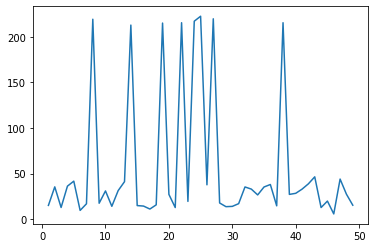

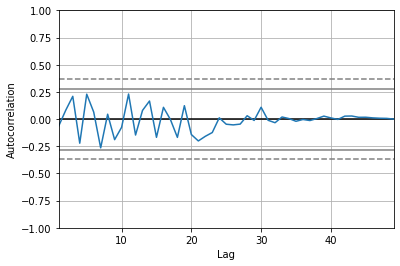

In [78]:
Temp3 = df['Temp3']
Temp3[1:100].plot()
pyplot.show()

autocorrelation_plot(Temp3[1:100])
pyplot.show()

pyplot.show()